<a href="https://colab.research.google.com/github/areummon/uni_projects/blob/main/Practica4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1WFDpAsvlnqfTD0pzkCBuho1JXdLn-NBB
!unzip cerebro.zip

Downloading...
From: https://drive.google.com/uc?id=1WFDpAsvlnqfTD0pzkCBuho1JXdLn-NBB
To: /content/cerebro.zip
100% 15.8M/15.8M [00:00<00:00, 31.2MB/s]
Archive:  cerebro.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflatin

In [ ]:
import os,cv2
from PIL import Image
from PIL import ImageMath
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

yes_images_path = './yes'
no_images_path = './no'

In [ ]:
yes_image_list = []
no_image_list = []

yes_folder_path = yes_images_path
no_folder_path = no_images_path

yes_image_files = [f for f in os.listdir(yes_folder_path) if f.endswith('.jpg') or f.endswith('.JPG') or f.endswith('.jpeg')]
no_image_files = [f for f in os.listdir(no_folder_path) if f.endswith('.jpg') or f.endswith('.JPG') or f.endswith('.jpeg')]

# Tamaño al que se convertirá cada imágen para poder ser manejada.
target_size = (224, 224)

# Todas las imágenes se convierten a RGB para tener un color estandarizado y no tener entradas nulas en la matriz de pixeles de
# cada imágen
for image_file in yes_image_files:
    img = Image.open(os.path.join(yes_folder_path, image_file)).convert('RGB')
    img = img.resize(target_size) # El cambio de tamaño de cada imágen a uno estándar
    img_array = np.array(img) / 255.0 # Se normaliza para que los valores sean entre 0 y 1 de punto flotante
    yes_image_list.append(img_array.flatten()) # Se convierte cada arreglo de pixeles en un arreglo de 1 dimensión
for image_file in no_image_files:
    img = Image.open(os.path.join(no_folder_path, image_file)).convert('RGB')
    img = img.resize(target_size) # El cambio de tamaño de cada imágen a uno estándar
    img_array = np.array(img) / 255.0 # Se normaliza para que los valores sean entre 0 y 1 de punto flotante
    no_image_list.append(img_array.flatten()) # Se convierte cada arreglo de pixeles en un arreglo de 1 dimnersión

yes_df = pd.DataFrame(yes_image_list)
no_df = pd.DataFrame(no_image_list)

In [ ]:
# Se concatenan ambos arreglos para poder crear las etiquetas en train_test_split
all_images = pd.concat([yes_df, no_df])

# Se usara 1 para las imágenes que si tengan el tumor y 0 para los que no
yes_labels = np.ones(len(yes_df))
no_labels = np.zeros(len(no_df))
all_labels = np.concatenate([yes_labels, no_labels])

X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)
X_train = torch.tensor(X_train.values, dtype=torch.float32)  #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

X_test = torch.tensor(X_test.values, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Creación del dataset
class BrainTumorDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

train_dataset = BrainTumorDataset(X_train, y_train)
test_dataset = BrainTumorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# La red neuronal
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()
    self.fc1 = nn.Linear(150528, 128)
    self.simg = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)

  def forward(self, x):
    x = self.fc1(x)
    x = self.simg(x)
    x = self.fc2(x)
    x = self.simg(x)
    x = self.fc3(x)
    return x

model = NeuralNet()
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Entrenamiento
epochs = 35
for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/35, Loss: 0.7180834114551544
Epoch 2/35, Loss: 0.6535692363977432
Epoch 3/35, Loss: 0.5333018377423286
Epoch 4/35, Loss: 0.5297535806894302
Epoch 5/35, Loss: 0.48319877684116364
Epoch 6/35, Loss: 0.4618360325694084
Epoch 7/35, Loss: 0.42098478227853775
Epoch 8/35, Loss: 0.3993181511759758
Epoch 9/35, Loss: 0.3954126611351967
Epoch 10/35, Loss: 0.37127476185560226
Epoch 11/35, Loss: 0.34147311747074127
Epoch 12/35, Loss: 0.29159505292773247
Epoch 13/35, Loss: 0.3232986144721508
Epoch 14/35, Loss: 0.3011866547167301
Epoch 15/35, Loss: 0.2889851704239845
Epoch 16/35, Loss: 0.33146511018276215
Epoch 17/35, Loss: 0.37920165061950684
Epoch 18/35, Loss: 0.2610231228172779
Epoch 19/35, Loss: 0.30436502397060394
Epoch 20/35, Loss: 0.2370089665055275
Epoch 21/35, Loss: 0.20678723976016045
Epoch 22/35, Loss: 0.22253958880901337
Epoch 23/35, Loss: 0.19247859716415405
Epoch 24/35, Loss: 0.2042958214879036
Epoch 25/35, Loss: 0.18464267626404762
Epoch 26/35, Loss: 0.17181118577718735
Epoch 27

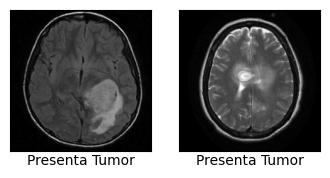

In [ ]:
# Grafica un par de imágenes
import matplotlib.pyplot as plt

def plot_random_samples(X, Y, num_samples=2, img_shape=(224, 224, 3)):
    indices = np.random.choice(range(0, X.shape[0]), size=num_samples)
    # Dado que las imágenes se "aplanaron" para poder ser usadas como dataframes
    # Se tienen que transformar a su forma original, esto para que se puedan ver
    X_subset = X[indices].reshape(-1, *img_shape)
    Y_subset = Y[indices]

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples *2, 2))
    for i, ax in enumerate(axes):
      image = X_subset[i]
      ax.imshow(image, cmap='gray')
      # Para quitarle las demás etiquetas a las imágenes
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

      label_text = "Presenta Tumor" if Y_subset[i] == 1 else "Sin Tumor"
      ax.text(0.5, -0.1, label_text, ha='center', transform=ax.transAxes)
    plt.show()

plot_random_samples(X_train, y_train)

Precision: 80.3921568627451%


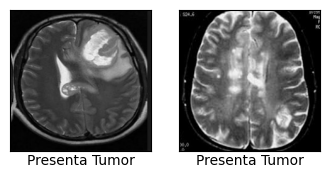

In [ ]:
model.eval()
correct = 0 #Numero de predicciones correctas
total = 0 #total

with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predicted= torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy= 100 * correct / total
print(f"Precision: {accuracy}%")

with torch.no_grad():
  for images, labels in test_loader:
    outputs = model(images)
    _, predicted= torch.max(outputs.data, 1)

plot_random_samples(images, predicted)